Импорт библиотек

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

In [ ]:
# Загрузка данных из CSV-файла
data = pd.read_csv("/content/sample_data/fish_train.csv")

# Выделение признаков (X) и целевой переменной (y)
X = data.drop('Species', axis=1)  # Все столбцы, кроме 'Species'
X = X.drop('Weight', axis=1)  # Все столбцы, кроме 'Species'
y = data['Weight']
z = data['Species']

# Разбиение данных на обучающую и тестовую выборки со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11,stratify=z)
print(X_train, X_test)

     Length1  Length2  Length3   Height   Width
97      23.6     25.2     27.9   7.0866  3.9060
37      40.2     43.5     46.0  12.6040  8.1420
21      37.0     40.0     42.5  11.7300  7.2250
40      21.2     23.0     25.8  10.3458  3.6636
116     37.3     40.0     43.5  12.3540  6.5250
..       ...      ...      ...      ...     ...
8       24.1     26.5     29.3   8.1454  4.2485
78      43.2     46.0     48.7   7.7920  4.8700
95      14.3     15.5     17.4   6.5772  2.3142
58      34.0     36.5     39.0  10.8810  6.8640
64      30.5     32.8     34.0  10.0300  6.0180

[95 rows x 5 columns]      Length1  Length2  Length3   Height   Width
71      21.5     23.5     25.0   6.2750  3.7250
106     11.7     12.4     13.5   2.4300  1.2690
23      22.0     23.4     26.7   6.9153  3.6312
91      16.2     18.0     19.2   5.2224  3.3216
104     31.7     34.0     37.8   5.7078  4.1580
108     33.5     37.0     42.6  18.9570  6.6030
49      19.8     21.5     24.1   9.7364  3.1571
103     19.0     

Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [ ]:
import numpy as np

mean_width_train = np.mean(X_train['Width'])

print("Среднее значение ширины в тренировочной выборке:", mean_width_train)

Среднее значение ширины в тренировочной выборке: 4.498425263157893


# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.8244231342772975


# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

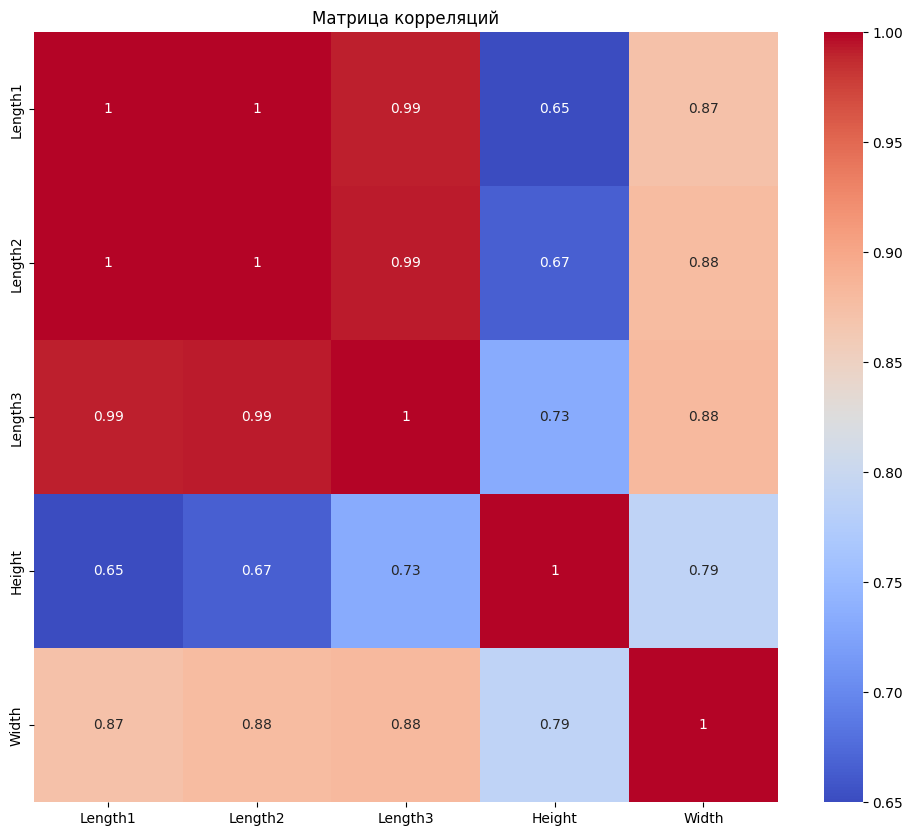

Length1  Length2    0.999431
Length2  Length1    0.999431
         Length3    0.993158
dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Вычисляем матрицу корреляций для числовых признаков в тренировочном наборе
corr_matrix = X_train.corr()

# Визуализируем матрицу корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

# Находим тройку наиболее коррелированных пар признаков (по абсолютной величине корреляции)
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs != 1]  # Убираем корреляцию признака с самим собой
top_corr_pairs = corr_pairs.head(3)
print(top_corr_pairs)

Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент.

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков.

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты.

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Выбираем три наиболее коррелированные признака (замените 'feature1', 'feature2', 'feature3' на ваши реальные названия)
selected_features = ['Length1', 'Length2', 'Length3']
X_train_selected = X_train[selected_features]

# Стандартизация данных (необходима для PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

# Создание и обучение модели PCA
pca = PCA(n_components=3, svd_solver='full')
pca.fit(X_train_scaled)

# Объясненная дисперсия для каждой компоненты
explained_variance_ratio = pca.explained_variance_ratio_
print('Объясненная дисперсия для каждой компоненты:', explained_variance_ratio)

# Доля объясненной дисперсии первой компонентой
print('Доля объясненной дисперсии первой компонентой:', explained_variance_ratio[0])

# Преобразование данных к новым координатам
X_train_pca = pca.transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test[selected_features])  # Стандартизация тестовых данных
X_test_pca = pca.transform(X_test_scaled)

# Создание нового признака Lengths для тренировочных и тестовых данных
X_train['Lengths'] = X_train_pca[:, 0]
X_test['Lengths'] = X_test_pca[:, 0]

# Удаление старых признаков для тренировочных и тестовых данных
X_train.drop(selected_features, axis=1, inplace=True)
X_test.drop(selected_features, axis=1, inplace=True)

Объясненная дисперсия для каждой компоненты: [9.96266706e-01 3.61430078e-03 1.18993031e-04]
Доля объясненной дисперсии первой компонентой: 0.9962667061885203


Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [ ]:
# < ENTER YOUR CODE HERE >

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.8210806279599667


Видно, что точность значительно не изменилась.

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

In [ ]:
# < ENTER YOUR CODE HERE >

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

In [ ]:
# < ENTER YOUR CODE HERE >

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [ ]:
# Возведение в куб выбранных столбцов
wc = X_train['Width']**3
hc = X_train['Height']**3
lc = X_train['Lengths']**3

# Вычисление среднего значения для Width_cubed
mean_width_cubed = wc.mean()
print("Среднее значение Width_cubed:", mean_width_cubed)

Среднее значение Width_cubed: 129.56198433393484


Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [ ]:
# Возведение в куб выбранных столбцов для тренировочных и тестовых данных
for col in ['Width', 'Height', 'Lengths']:
    X_train[col] = X_train[col]**3
    X_test[col] = X_test[col]**3

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.9706275133931405


Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [ ]:
df = pd.DataFrame(z)
xt = pd.get_dummies(df)

xt_train = xt.iloc[:len(X_train)]
xt_test = xt.iloc[len(X_train):]

X_train_new = pd.concat([X_train, xt_train], axis=1)
X_test_new = pd.concat([X_test, xt_test], axis=1)

print(X_train_new, X_test_new)

#model = LinearRegression()
#model.fit(X_train_new, y_train)

#y_pred = model.predict(X_test_new)
#r2 = r2_score(y_test, y_pred)
#print("Коэффициент детерминации R^2:", r2)

          Height       Width    Lengths Species_Bream Species_Parkki  \
97    355.888340   59.593201  -0.169371           NaN            NaN   
37   2002.281725  539.750799  14.957138         False          False   
21   1613.964717  377.149516   6.679238         False          False   
40   1107.368679   49.172711  -0.822021         False           True   
116  1885.483738  277.805953   7.464917           NaN            NaN   
..           ...         ...        ...           ...            ...   
67           NaN         NaN        NaN         False          False   
71           NaN         NaN        NaN         False          False   
77           NaN         NaN        NaN         False          False   
82           NaN         NaN        NaN         False          False   
91           NaN         NaN        NaN         False          False   

    Species_Perch Species_Pike Species_Roach Species_Smelt Species_Whitefish  
97            NaN          NaN           NaN           N

И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

In [ ]:
# < ENTER YOUR CODE HERE >

На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.